<a href="https://colab.research.google.com/github/akib26/TwitterSentimentAnalysis/blob/v2/TWT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Twitter

In [226]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split # function for splitting data to train and test sets
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.metrics import accuracy
from nltk.metrics import ConfusionMatrix

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [227]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [228]:
data = pd.read_csv('Sentiment.csv')
data = data[['text','sentiment']]
data.groupby('sentiment').count()

,text
sentiment,
Negative,8493
Neutral,3142
Positive,2236


In [229]:
# label correction
sia = SentimentIntensityAnalyzer()
for index,row in data.iterrows():
  if sia.polarity_scores(row.text)["compound"] > 0:
    row.sentiment='Positive'
  elif sia.polarity_scores(row.text)["compound"] < 0:
    row.sentiment='Negative'
  else: 
    row.sentiment='Neutral'
data.groupby('sentiment').count()

,text
sentiment,
Negative,3886
Neutral,4478
Positive,5507


In [230]:
data.to_csv('Sentiment1.csv')

In [231]:
data = pd.read_csv('Sentiment1.csv')
# Keeping only the neccessary columns
data = data[['text','sentiment']]
# Splitting the dataset into train and test set
X=data['text']
y=data['sentiment']

In [232]:
X_train,X_test,y_train, y_test = train_test_split(data,y,test_size = 0.1,random_state=1,stratify=y)
#train,test=train_test_split(data,test_size=0.1)
data_pos = data[ data['sentiment'] == 'Positive']
data_pos = data_pos['text']
data_neg = data[ data['sentiment'] == 'Negative']
data_neg = data_neg['text']
data_neu = data[ data['sentiment'] == 'Neutral']
data_neu = data_neu['text']


In [233]:
X_train.shape,X_test.shape,y_train.shape, y_test.shape

((12483, 2), (1388, 2), (12483,), (1388,))

In [234]:
def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

Positive words


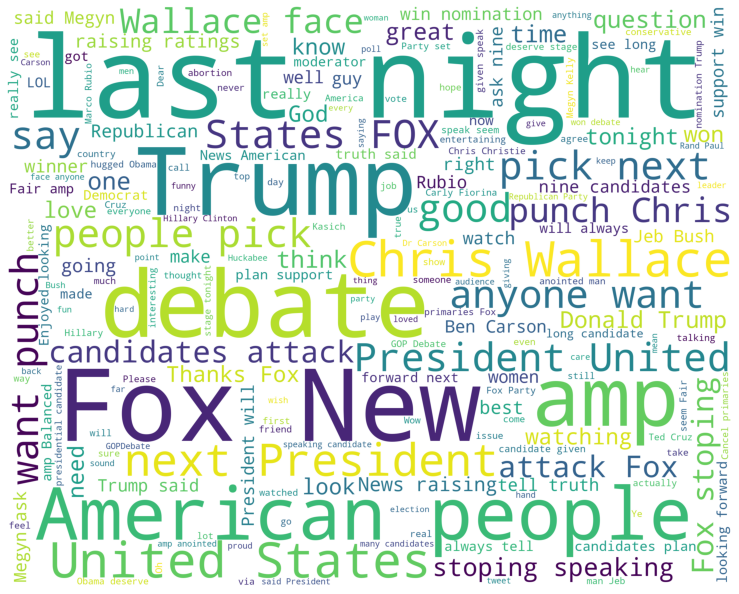

In [235]:
print("Positive words")
wordcloud_draw(data_pos,'white')


Negative words


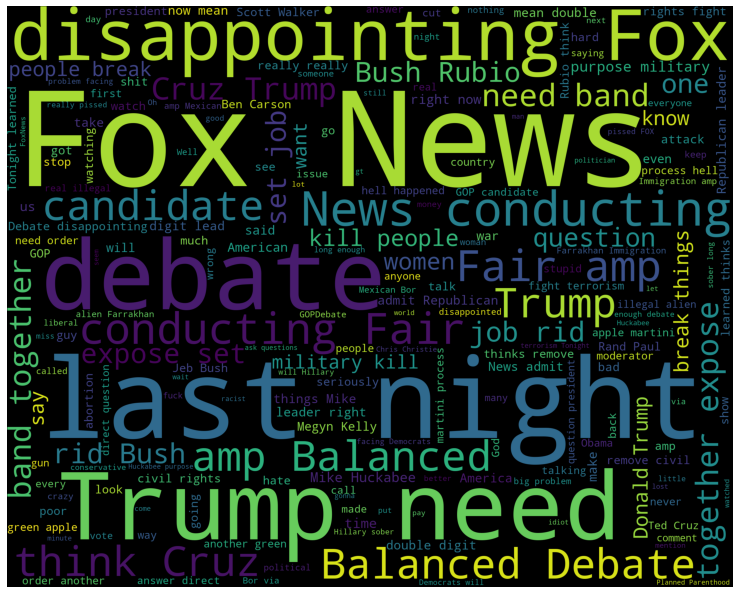

In [236]:
print("Negative words")
wordcloud_draw(data_neg)


Neutral words


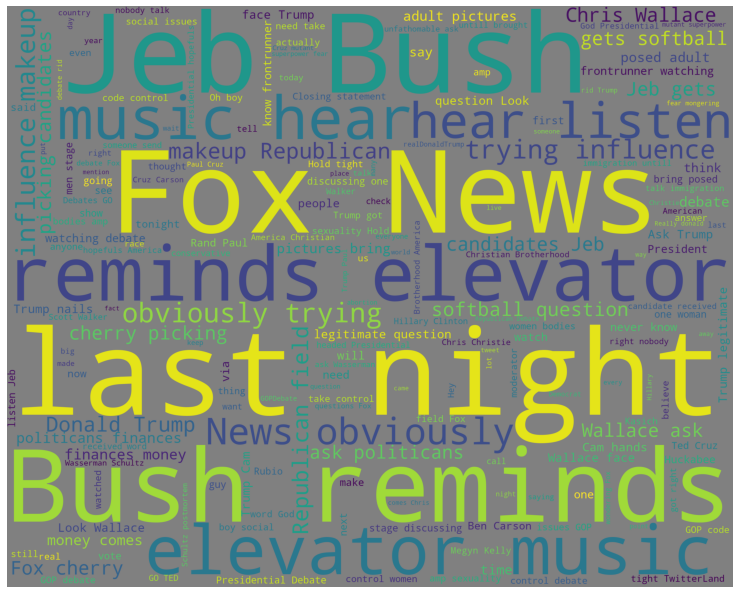

In [237]:
print("Neutral words")
wordcloud_draw(data_neu,'grey')

Twitter most frequent words


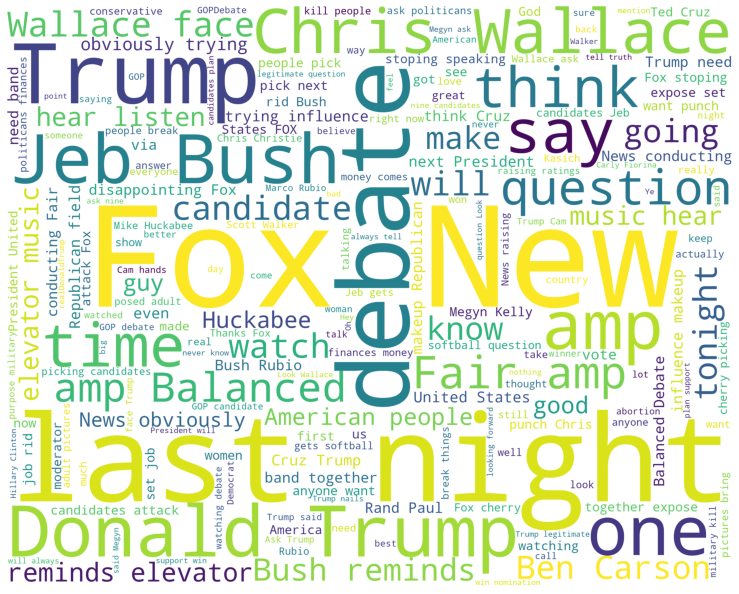

In [238]:
print("Twitter most frequent words")
wordcloud_draw(data['text'],'white')

In [239]:
tweets = []
stopwords_set = set(stopwords.words("english"))
for index,row in X_train.iterrows():
    words_filtered = [e.lower() for e in row.text.split() if len(e) >= 3]
    words_cleaned = [word for word in words_filtered
        if 'http' not in word
        and not word.startswith('@')
        and not word.startswith('#')
        and word != 'RT']
    words_without_stopwords = [word for word in words_cleaned if not word in stopwords_set]
    tweets.append((words_without_stopwords, row.sentiment))

In [240]:
# Extracting word features
def get_words_in_tweets(tweets):
    all = []
    for (words, sentiment) in tweets:
        all.extend(words)
    return all
 
def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    features = wordlist.keys()
    return features
w_features = get_word_features(get_words_in_tweets(tweets))
 
def extract_features(document):
    document_words = set(document)
    features = {}
    for word in w_features:
        features['contains(%s)' % word] = (word in document_words)
    return features

In [241]:
# Training the Naive Bayes classifier
training_set = nltk.classify.apply_features(extract_features,tweets)
classifier = nltk.NaiveBayesClassifier.train(training_set)

In [242]:
predicted=[]
for obj in X_test['text']:
  res=classifier.classify(extract_features(obj.split()))
  predicted.append(res)

In [243]:
y_test_list=y_test.tolist()

In [244]:

print(ConfusionMatrix(y_test_list, predicted).pretty_format(sort_by_count=True))

         |   P       N |
         |   o   N   e |
         |   s   e   g |
         |   i   u   a |
         |   t   t   t |
         |   i   r   i |
         |   v   a   v |
         |   e   l   e |
---------+-------------+
Positive |<439> 88  24 |
 Neutral |  78<357> 13 |
Negative |  92  62<235>|
---------+-------------+
(row = reference; col = test)



The numbers embedded in <> are the true positives (tp)meaning correctly classified.


*   rows refer to actual test set sentiment
*   columns refer to predicted sentiment by our naive bayes classifier





In [245]:
print("Accuracy:", accuracy(y_test_list, predicted))

Accuracy: 0.7427953890489913


In [246]:
user_input=input("Enter your tweet")
res=classifier.classify(extract_features(user_input.split()))
print(res)

Enter your tweetThe team is excited 
Positive


In [247]:
import pickle
mymodel = 'naive_finalized_model.sav'
pickle.dump(classifier, open(mymodel, 'wb'))

# Facebook

In [248]:
fb = pd.read_csv('fb_sentiment.csv')
fb = fb[['text','sentiment']]
print(fb.head())

                                                text sentiment
0  Drug Runners and  a U.S. Senator have somethin...   Neutral
1  Heres a single, to add, to Kindle. Just read t...   Neutral
2  If you tire of Non-Fiction.. Check out http://...   Neutral
3    Ghost of Round Island is supposedly nonfiction.   Neutral
4  Why is Barnes and Nobles version of the Kindle...  Negative


In [249]:

for index,row in fb.iterrows():
  if sia.polarity_scores(row.text)["compound"] > 0:
    row.sentiment='Positive'
  elif sia.polarity_scores(row.text)["compound"] < 0:
    row.sentiment='Negative'
  else: 
    row.sentiment='Neutral'
fb.groupby('sentiment').count()

,text
sentiment,
Negative,106
Neutral,160
Positive,734


In [250]:
fbpredicted=[]
for obj in fb['text']:
  res=classifier.classify(extract_features(obj.split()))
  fbpredicted.append(res)

In [251]:
fbactual=fb['sentiment'].tolist()

In [252]:

print(ConfusionMatrix(fbactual, fbpredicted).pretty_format(sort_by_count=True))

         |   P       N |
         |   o   N   e |
         |   s   e   g |
         |   i   u   a |
         |   t   t   t |
         |   i   r   i |
         |   v   a   v |
         |   e   l   e |
---------+-------------+
Positive |<526>143  65 |
 Neutral |  37<111> 12 |
Negative |  42  26 <38>|
---------+-------------+
(row = reference; col = test)



In [253]:
print("Accuracy:", accuracy(fbactual, fbpredicted))

Accuracy: 0.675


In [254]:
fb_pos = fb[ fb['sentiment'] == 'Positive']
fb_pos = fb_pos['text']
fb_neg = fb[ fb['sentiment'] == 'Negative']
fb_neg = fb_neg['text']
fb_neu = fb[ fb['sentiment'] == 'Neutral']
fb_neu = fb_neu['text']

Psoitive words


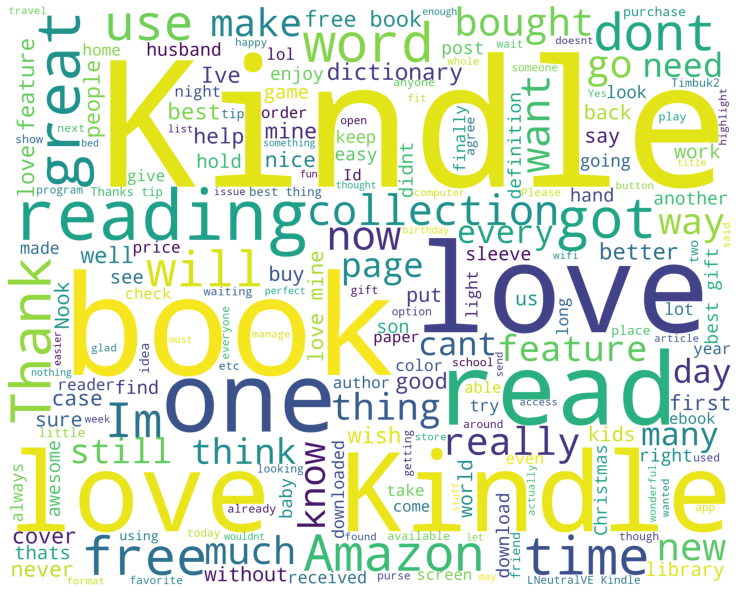

In [255]:
print("Psoitive words")
wordcloud_draw(fb_pos,'white')

Negative words


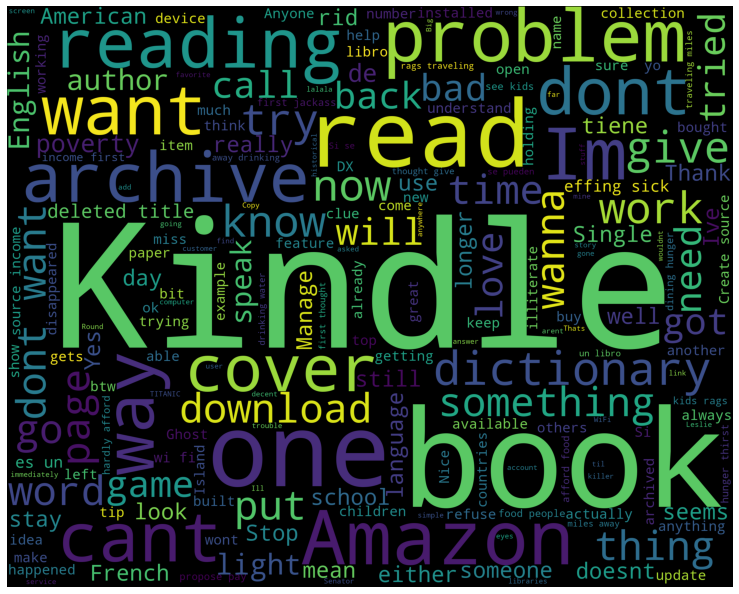

In [256]:
print("Negative words")
wordcloud_draw(fb_neg)

Neutralwords


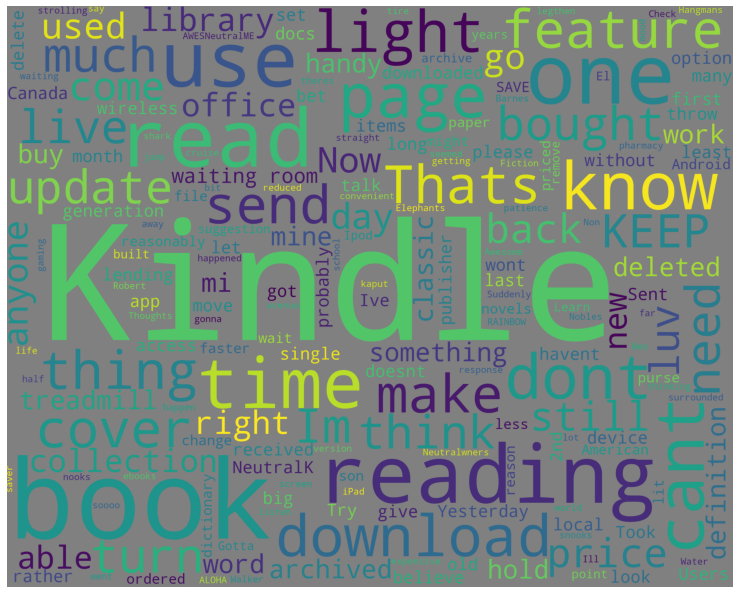

In [257]:
print("Neutralwords")
wordcloud_draw(fb_neu,'grey')

FB dataset most frequent  words


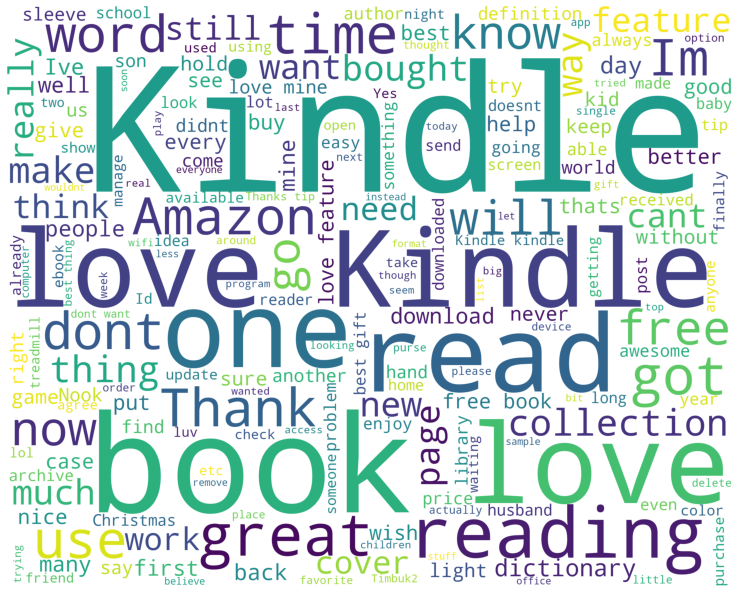

In [258]:
print("FB dataset most frequent  words")
wordcloud_draw(fb['text'],'white')
